In [66]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

import glob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 150
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def make_best_spec_high_sens_scorer(min_sensitivity: float = 0.98):

    def get_best_spec_high_sens(ytest, yscore):
        thrs = np.unique(yscore)
        best_spec = 0
        for thr in thrs:
            preds = yscore > thr
            tn, fp, fn, tp = metrics.confusion_matrix(ytest, preds).ravel()
            specificity = tn / (tn + fp)
            sensitivity = tp / (tp + fn)

            if sensitivity >= min_sensitivity:
                best_spec = max(specificity, best_spec)
        return best_spec

    return get_best_spec_high_sens


def get_best_args(val_df_group, model_name):
    return val_df_group.filter(regex=model_name, axis=0).round(2).sort_values(
        by=['spec90', 'aps'], kind='mergesort', ascending=False)['args'].iloc[0]

In [24]:
DATASET = 'tbi'

In [25]:
def plott(model_name, sens, spec, ppv, ax):
    if 'pecarn' in model_name.lower():
        ax.plot(sens[0], spec[0], '.-', label=model_name)
    else:
        ax.plot(sens, spec, '.-', label=model_name)

def multiplot(paths, ax, suffix=""):
    for model_file in paths:
        basename = os.path.basename(model_file).split('.')[0]
        dct = pkl.load(open(model_file, 'rb'))
        plott(basename, dct['sens_tune'], dct['spec_tune'], dct['ppv_tune'], ax)
    ax.legend(frameon=False, loc='best')
    ax.set_xlim(0.5, 1.05)
    # ax.set_ylim(0, 0.2)

def multiseedplot(group='all'):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(9):
        paths = sorted(glob.glob(f'results/{DATASET}/seed_{i}/{group}/*.pkl'))
        multiplot(paths, axes[i // 3, i % 3], group)
    plt.xlabel('sens')
    plt.ylabel('spec')
    plt.tight_layout()

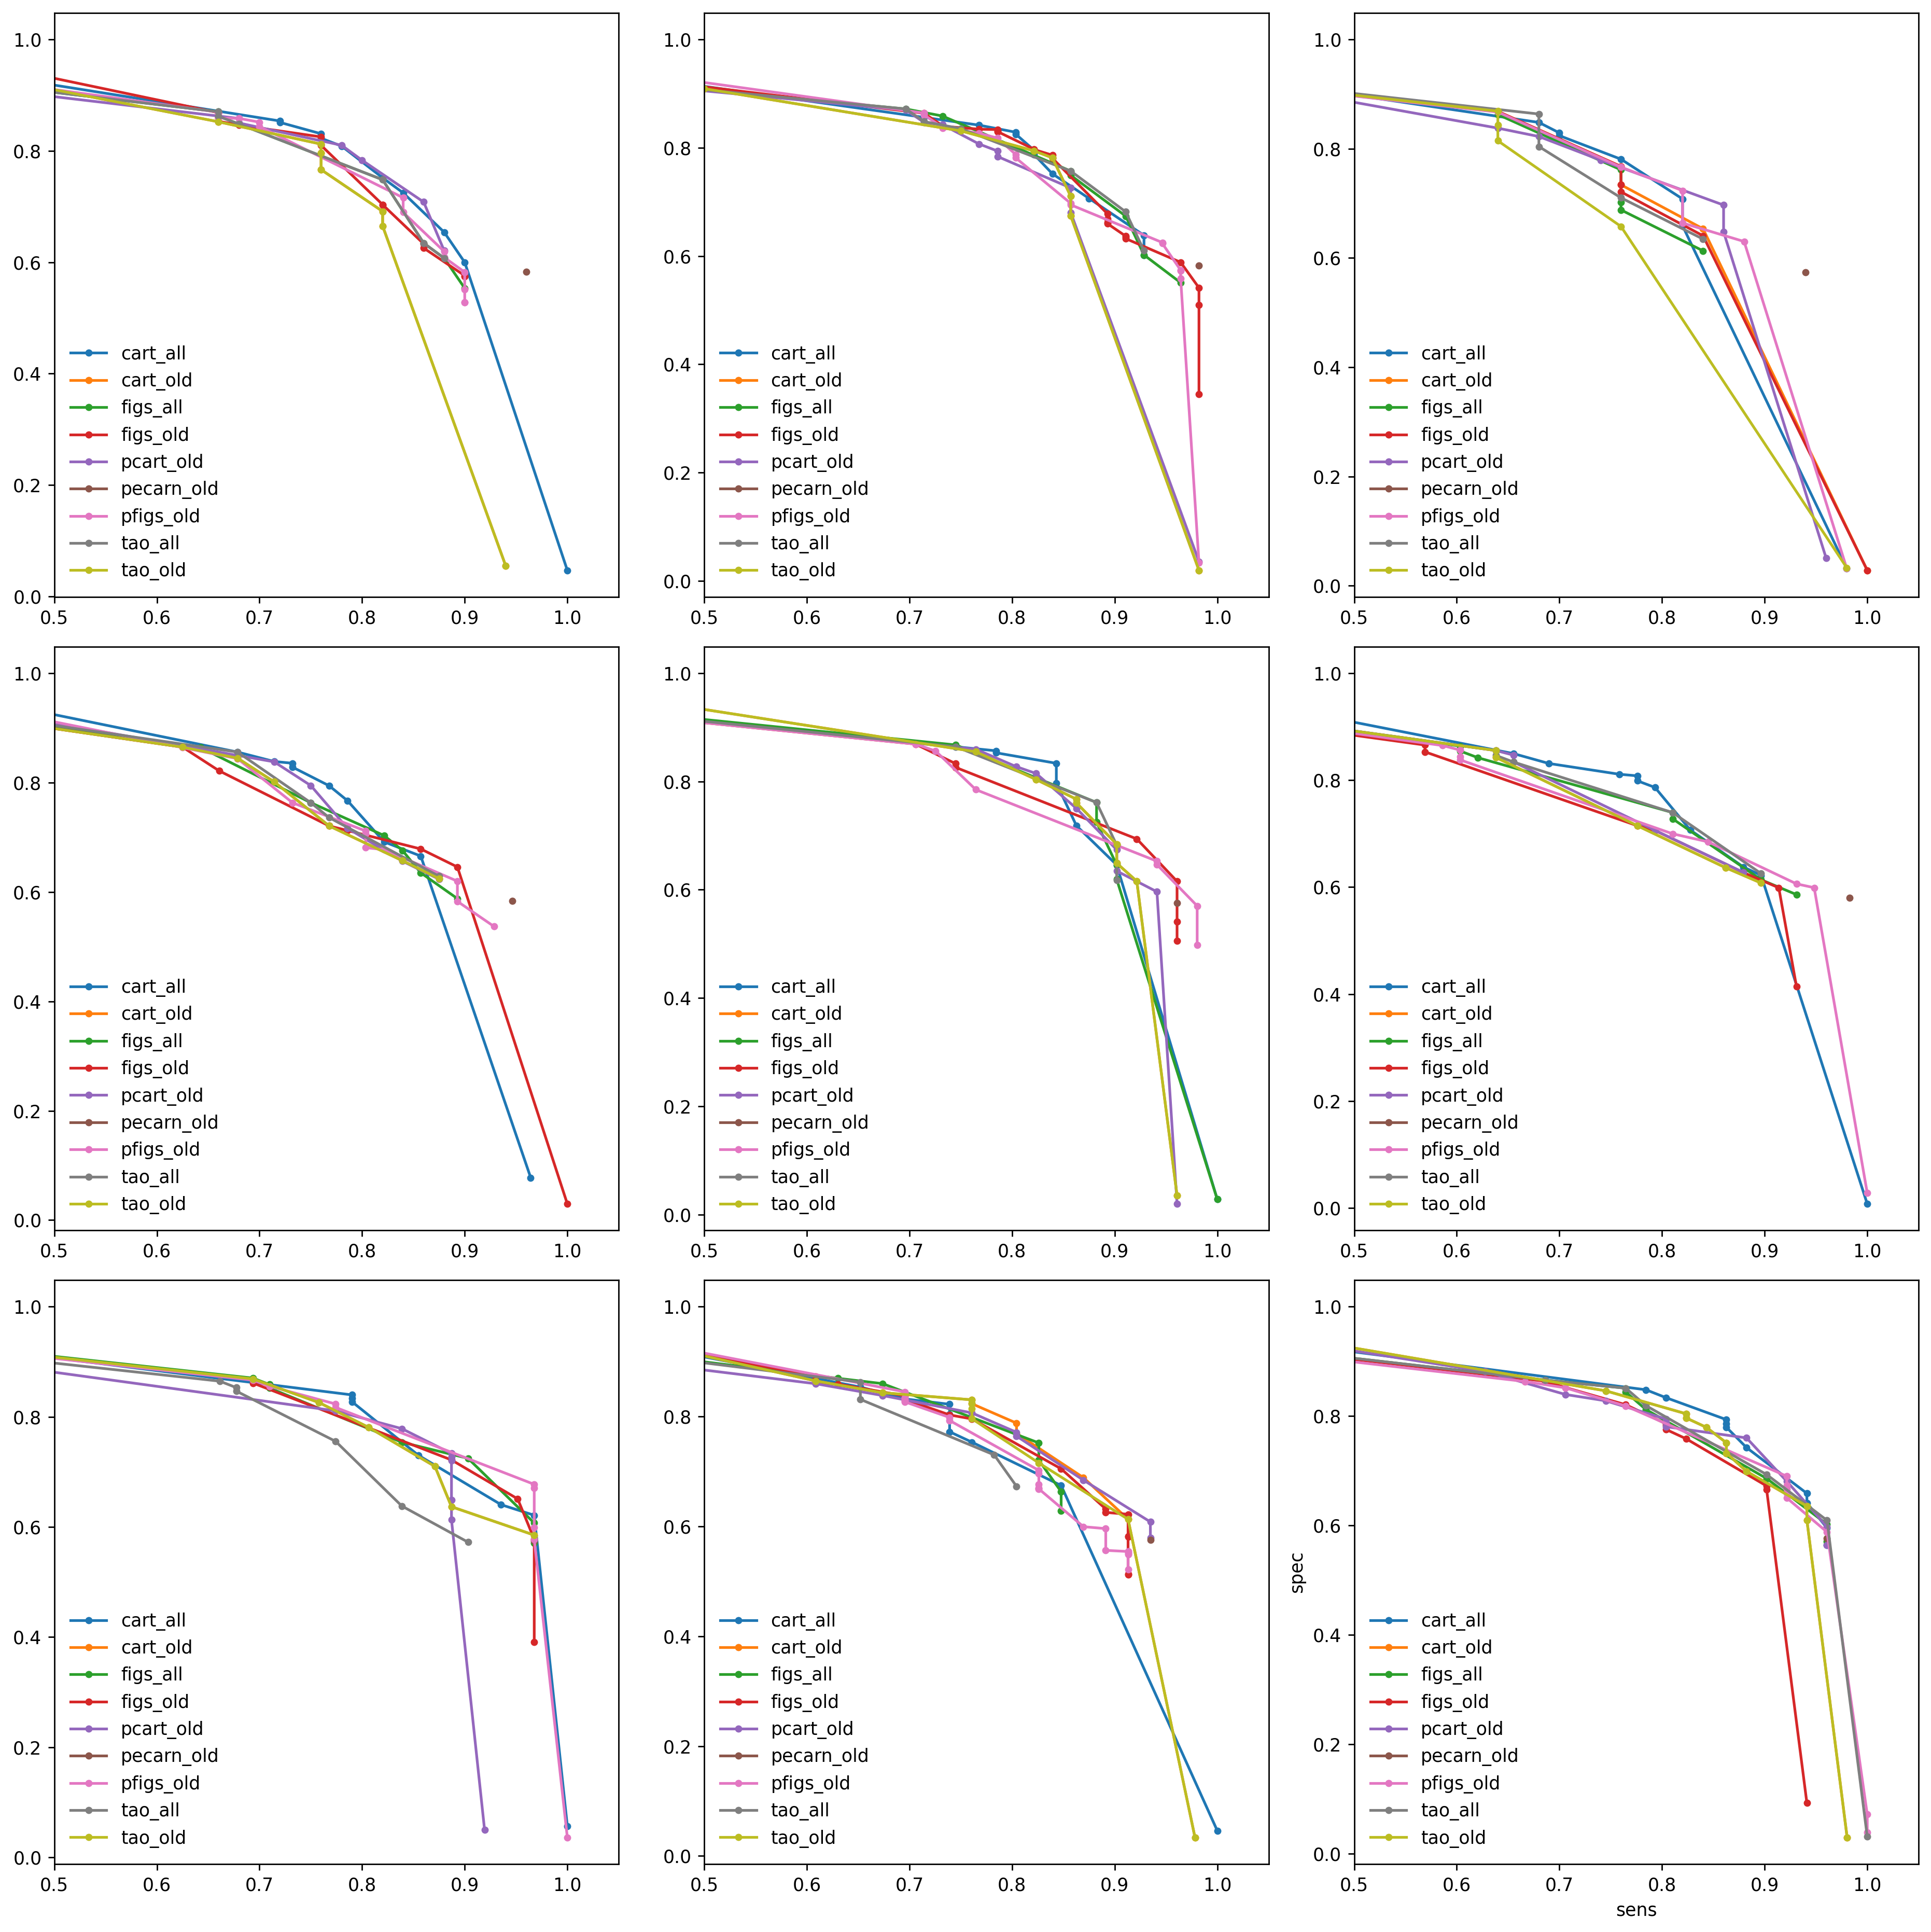

In [26]:
multiseedplot(group='old')

In [27]:
for seed in range(10):
    dct = pkl.load(open(f'results/{DATASET}/seed_{seed}/best_models.pkl', 'rb'))
    print(seed, dct['pfigs_old'].max_rules, dct['pfigs_young'].max_rules, 
        dct['figs_old'].max_rules, dct['figs_young'].max_rules, dct['figs_all'].max_rules)

0 12 8 12 8 8
1 12 16 12 8 8
2 8 12 8 8 8
3 8 12 8 8 8
4 8 8 8 8 8
5 12 8 8 8 8
6 12 8 8 8 8
7 16 12 12 8 8
8 16 8 16 8 8
9 8 12 8 8 8


In [28]:
SPLIT_SEED = 4
pmodel_df = pd.read_csv(f'results/{DATASET}/seed_{SPLIT_SEED}/pmodel_val.csv').set_index('Unnamed: 0')
PMODEL = get_best_args(pmodel_df, f'^PFIGS')

In [29]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [30]:
results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(0, 9, 2)] + ['aps', 'auc', 'acc', 'f1', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None):
    pred_proba_args = (X_test,)
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    f1 = metrics.f1_score(y_test, model.predict(X_test))
    results[model_name] = spec_scores + [apc, auc, acc, f1, model_args]

In [31]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET != 'csi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET != 'csi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        else:
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [32]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [33]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

In [36]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

In [37]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])

X_prop = X_df_prop.values
X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test = model_selection.train_test_split(X_prop, y_prop, test_size=0.2, random_state=SPLIT_SEED)

In [42]:
# if PMODEL == 'GB':
#     prop_model = GradientBoostingClassifier()
# elif PMODEL == 'L':
#     prop_model = LogisticRegression(C=2.7825594, penalty='l2', solver='liblinear')

# prop_model.fit(X_prop_train_full, y_prop_train_full)

In [43]:
# prop_model.C_

In [44]:
# prop_model.scores_[1.0].mean(axis=0)

In [45]:
# print('avg score for CV folds: ', prop_model.scores_[1.0][:, 4])

In [46]:
# prop_scores_train_full = prop_model.predict_proba(X_prop_train_full)[:, 1]

### data setup

In [58]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df.drop(columns=['AgeInYears'])
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
    feature_names = X_df_clean.columns.tolist()

X_train_full, X_test, y_train_full, y_test, is_group_1_train_full, is_group_1_test = (
    model_selection.train_test_split(X_df_clean, y, is_group_1, test_size=0.2, random_state=SPLIT_SEED))
X_train, X_val, y_train, y_val, is_group_1_train, is_group_1_val = (
    model_selection.train_test_split(X_train_full, y_train_full, is_group_1_train_full, test_size=0.25, random_state=SPLIT_SEED))

X_train_young, X_val_young, X_test_young = X_train[~is_group_1_train], X_val[~is_group_1_val], X_test[~is_group_1_test]
X_train_old, X_val_old, X_test_old = X_train[is_group_1_train], X_val[is_group_1_val], X_test[is_group_1_test]
y_train_young, y_val_young, y_test_young = y_train[~is_group_1_train], y_val[~is_group_1_val], y_test[~is_group_1_test]
y_train_old, y_val_old, y_test_old = y_train[is_group_1_train], y_val[is_group_1_val], y_test[is_group_1_test]

X_train_full_old, X_train_full_young = pd.concat((X_train_old, X_val_old)), pd.concat((X_train_young, X_val_young))
y_train_full_old, y_train_full_young = npcat((y_train_old, y_val_old)), npcat((y_train_young, y_val_young))

In [59]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])

cls_ratio_train_young = cls_ratio(y_train_young)
cls_ratio_train_old = cls_ratio(y_train_old)
cls_ratio_train = cls_ratio(y_train)

sw_train_young = y_train_young * cls_ratio_train_young + 1
sw_train_old = y_train_old * cls_ratio_train_old + 1
sw_train = y_train * cls_ratio_train + 1

sw_train_full_young = y_train_full_young * cls_ratio_train_young + 1
sw_train_full_old = y_train_full_old * cls_ratio_train_old + 1
sw_train_full = y_train_full * cls_ratio_train + 1

In [60]:
max_leaf_nodes_options = [8, 12, 16]
tao_iter_options = [1, 5]

In [61]:
def fit_models(model_cls, model_name, prop=False, tt=False, all=False):
    if tt:
        tao_iter_options_local = [0]
    elif model_cls == imodels.TaoTreeClassifier:
        tao_iter_options_local = tao_iter_options
    else:
        tao_iter_options_local = [None]

    for msize, tao_iter in itertools.product(max_leaf_nodes_options, tao_iter_options_local):
        if model_cls == DecisionTreeClassifier:
            model_args = {'max_leaf_nodes': msize}
        elif model_cls == imodels.FIGSClassifier:
            model_args = {'max_rules': msize}
        elif model_cls == imodels.TaoTreeClassifier:
            model_args = {'n_iters': tao_iter, 'model_args': {'max_leaf_nodes': msize}, 'update_scoring': 'average_precision'}

        young = model_cls(**model_args)
        old = model_cls(**model_args)
        whole = model_cls(**model_args)

        if not prop:
            young.fit(X_train_young, y_train_young, sample_weight=sw_train_young)
            old.fit(X_train_old, y_train_old, sample_weight=sw_train_old)
        else:
            young.fit(X_train, y_train, sample_weight=(1 - prop_scores_train) * sw_train)
            old.fit(X_train, y_train, sample_weight= prop_scores_train * sw_train)
        
        if tt:
            for _ in range(2):
                num_updates = young._tao_iter_cart(
                    X_train_old.values, y_train_old, young.model.tree_, 
                    X_train_young.values, y_train_young, sample_weight=sw_train_old, sample_weight_score=sw_train_young)
                if num_updates == 0:
                        break
        
            for _ in range(2):
                num_updates = old._tao_iter_cart(
                    X_train_young.values, y_train_young, old.model.tree_, 
                    X_train_old.values, y_train_old, sample_weight=sw_train_young, sample_weight_score=sw_train_old)
                if num_updates == 0:
                        break
                
        name_young = f'{model_name}_<2_{msize}'
        name_old = f'{model_name}_>2_{msize}'
        name_whole = f'{model_name}_all_{msize}'

        if tao_iter not in [None, 0] and not tt:
            name_young += f'_{tao_iter}'
            name_old += f'_{tao_iter}'
            name_whole += f'_{tao_iter}'

        log_results(young, name_young, X_val_young, y_val_young, model_args)
        log_results(old, name_old, X_val_old, y_val_old, model_args)

        if all:
            whole.fit(X_train, y_train, sw_train)
            log_results(whole, name_whole, X_val, y_val, model_args)

In [50]:
best_models = pkl.load(open(f'results/{DATASET}/seed_{SPLIT_SEED}/best_models.pkl', 'rb'))

### Visualizing best models

In [51]:
def vizfigs(name):
    best_models[name].feature_names_ = feature_names
    print(best_models[name])

In [52]:
vizfigs('figs_old')

------------
AMS <= 0.500 (Tree #0 root)
	LOCSeparate_No <= 0.500 (split)
		Val: 0.579 (leaf)
		SFxBas <= 0.500 (split)
			VomitStart_Not applicable <= 0.500 (split)
				HA_verb_1.0 <= 0.500 (split)
					Val: 0.127 (leaf)
					Val: 0.666 (leaf)
				High_impact_InjSev_High <= 0.500 (split)
					HASeverity_Severe <= 0.500 (split)
						HASeverity_Moderate <= 0.500 (split)
							Val: 0.026 (leaf)
							Val: 0.199 (leaf)
						Val: 0.653 (leaf)
					Val: 0.397 (leaf)
			Val: 0.914 (leaf)
	Val: 0.828 (leaf)



In [53]:
vizfigs('figs_young')

------------
AMS <= 0.500 (Tree #0 root)
	SFxPalp_No <= 0.500 (split)
		Val: 0.876 (leaf)
		High_impact_InjSev_High <= 0.500 (split)
			ActNorm <= 0.500 (split)
				AgeInMonth <= 9.500 (split)
					Val: 0.685 (leaf)
					Val: 0.000 (leaf)
				LOCSeparate_Suspected <= 0.500 (split)
					HemaLoc_Parietal/Temporal <= 0.500 (split)
						Val: 0.022 (leaf)
						Val: 0.343 (leaf)
					Val: 0.595 (leaf)
			AgeInMonth <= 6.500 (split)
				Val: 0.721 (leaf)
				Val: 0.243 (leaf)
	Val: 0.856 (leaf)



In [54]:
vizfigs('pfigs_old')

------------
AMS <= 0.500 (Tree #0 root)
	LOCSeparate_No <= 0.500 (split)
		Val: 0.580 (leaf)
		VomitStart_Not applicable <= 0.500 (split)
			Val: 0.582 (leaf)
			SFxBas <= 0.500 (split)
				SFxPalp_No <= 0.500 (split)
					Val: 0.691 (leaf)
					High_impact_InjSev_High <= 0.500 (split)
						HASeverity_Severe <= 0.500 (split)
							HASeverity_Moderate <= 0.500 (split)
								Val: 0.030 (leaf)
								Val: 0.203 (leaf)
							Val: 0.565 (leaf)
						Val: 0.319 (leaf)
				Val: 0.898 (leaf)
	Val: 0.829 (leaf)



In [55]:
vizfigs('pfigs_young')

------------
AMS <= 0.500 (Tree #0 root)
	SFxPalp_No <= 0.500 (split)
		Val: 0.857 (leaf)
		High_impact_InjSev_High <= 0.500 (split)
			HemaLoc_Parietal/Temporal <= 0.500 (split)
				NeuroDMotor <= 0.500 (split)
					VomitStart_1-4 hrs after event <= 0.500 (split)
						AgeInMonth <= 0.500 (split)
							Val: 0.404 (leaf)
							Val: 0.013 (leaf)
						Val: 0.385 (leaf)
					Val: 0.982 (leaf)
				Val: 0.409 (leaf)
			AgeInMonth <= 6.500 (split)
				Val: 0.714 (leaf)
				Val: 0.308 (leaf)
	Val: 0.855 (leaf)



In [56]:
vizfigs('figs_all')

------------
AMS <= 0.500 (Tree #0 root)
	High_impact_InjSev_High <= 0.500 (split)
		SFxBas <= 0.500 (split)
			SFxPalp_Yes <= 0.500 (split)
				Amnesia_verb_1.0 <= 0.500 (split)
					HemaLoc_Parietal/Temporal <= 0.500 (split)
						VomitNbr_>2 times <= 0.500 (split)
							Val: 0.053 (leaf)
							Val: 0.393 (leaf)
						HA_verb_0.0 <= 0.500 (split)
							Val: 0.564 (leaf)
							Val: 0.000 (leaf)
					Val: 0.511 (leaf)
				Val: 0.935 (leaf)
			Val: 0.919 (leaf)
		Val: 0.598 (leaf)
	Val: 0.835 (leaf)



### permutation importance

In [60]:
def get_all_features_used(figs):
    all_features = []
    def get_all_features_inner(tree):
        if tree.left is not None or tree.right is not None:
            all_features.append(tree.feature)
        if tree.left is not None:
            get_all_features_inner(tree.left)
        if tree.right is not None:
            get_all_features_inner(tree.right)
    for tree in figs.trees_:
        get_all_features_inner(tree)
    return np.sort(np.unique(all_features))

used_features = {}
for model in ['figs_all', 'pfigs_young', 'pfigs_old', 'figs_young', 'figs_old']:
    best_models[model].classes_ = np.unique(y_test_young)
    used_features[model] = get_all_features_used(best_models[model])

In [61]:
imps = {}
custom_score = metrics.make_scorer(make_best_spec_high_sens_scorer(0.8), greater_is_better=True, needs_proba=True)

In [62]:
# imps['figs_all'] = permutation_importance(best_models['figs_all'], X_train_full, y_train_full, scoring='f1', n_jobs=10, n_repeats=10)
# for model in ['pfigs_young', 'figs_young']:
#     imps[model] = permutation_importance(best_models[model], X_train_full_young, y_train_full_young, scoring='f1', n_jobs=10, n_repeats=10)
# for model in ['figs_old', 'pfigs_old']:
#     imps[model] = permutation_importance(best_models[model], X_train_full_old, y_train_full_old, scoring='f1', n_jobs=10, n_repeats=10)
# pkl.dump(imps, open(f'results/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'wb'))
imps = pkl.load(open(f'results/{DATASET}/seed_{SPLIT_SEED}/importances.pkl', 'rb'))

In [63]:
def imp_plot(model):
    imp_means = pd.Series(imps[model].importances_mean, index=feature_names)[used_features[model]]
    imp_means_sort_ind = imp_means.argsort()[::-1]
    imp_means = imp_means[imp_means_sort_ind]
    imp_means.plot.bar(yerr=imps[model].importances_std[used_features[model]][imp_means_sort_ind])
    plt.ylabel("Mean F1 decrease")
    plt.xticks(rotation=45, ha="right")

Text(0.5, 1.0, 'Permutation importances, FIGS on all ages')

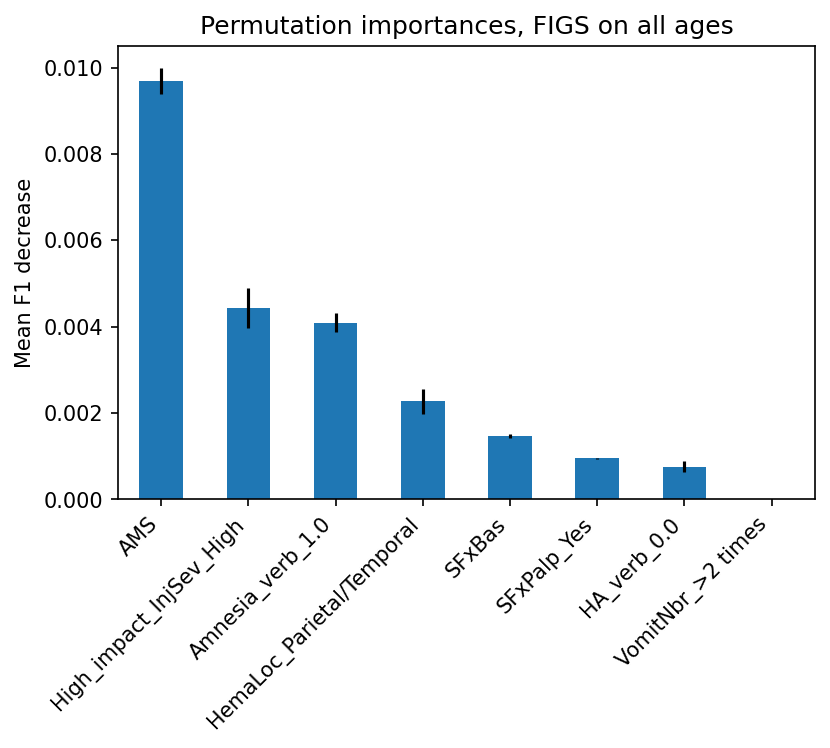

In [67]:
imp_plot('figs_all')
plt.title("Permutation importances, FIGS on all ages")

Text(0.5, 1.0, 'Permutation importances, FIGS on <2')

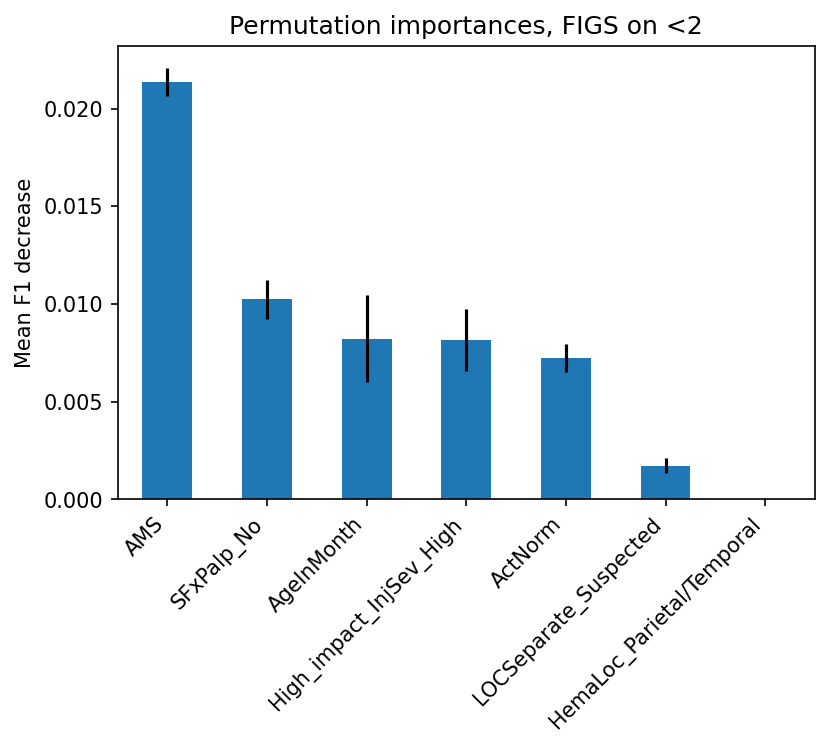

In [68]:
imp_plot('figs_young')
plt.title("Permutation importances, FIGS on <2")

Text(0.5, 1.0, 'Permutation importances, FIGS on >2')

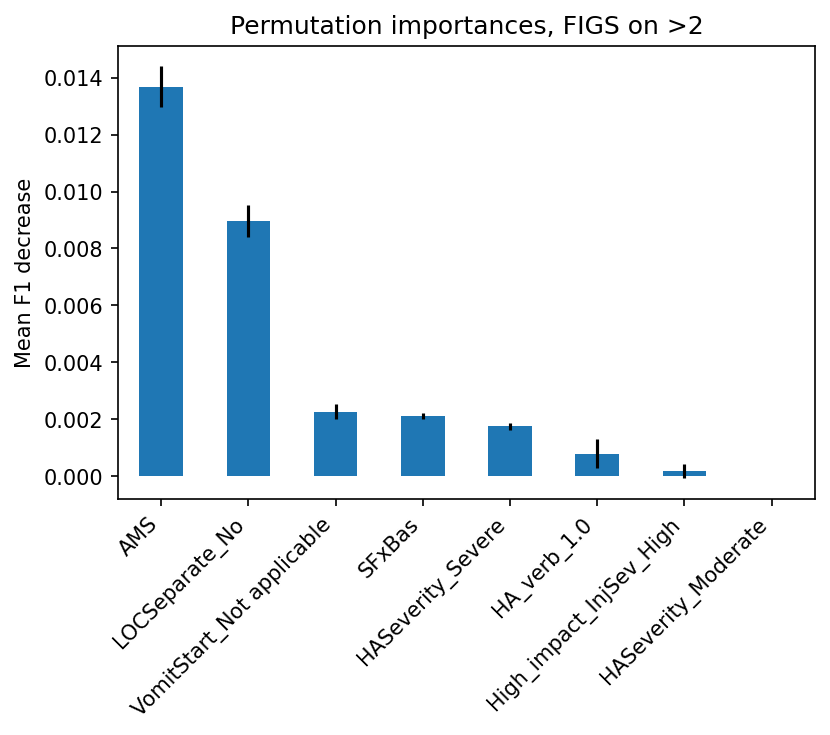

In [69]:
imp_plot('figs_old')
plt.title("Permutation importances, FIGS on >2")

Text(0.5, 1.0, 'Permutation importances, TFIGS on <2')

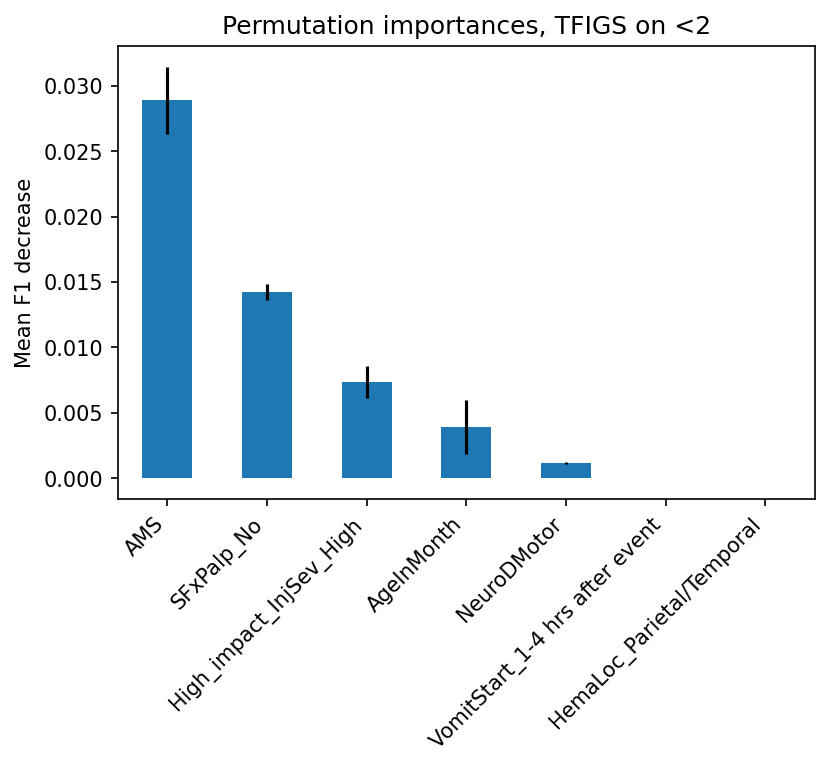

In [70]:
imp_plot('pfigs_young')
plt.title("Permutation importances, TFIGS on <2")

Text(0.5, 1.0, 'Permutation importances, TFIGS on >2')

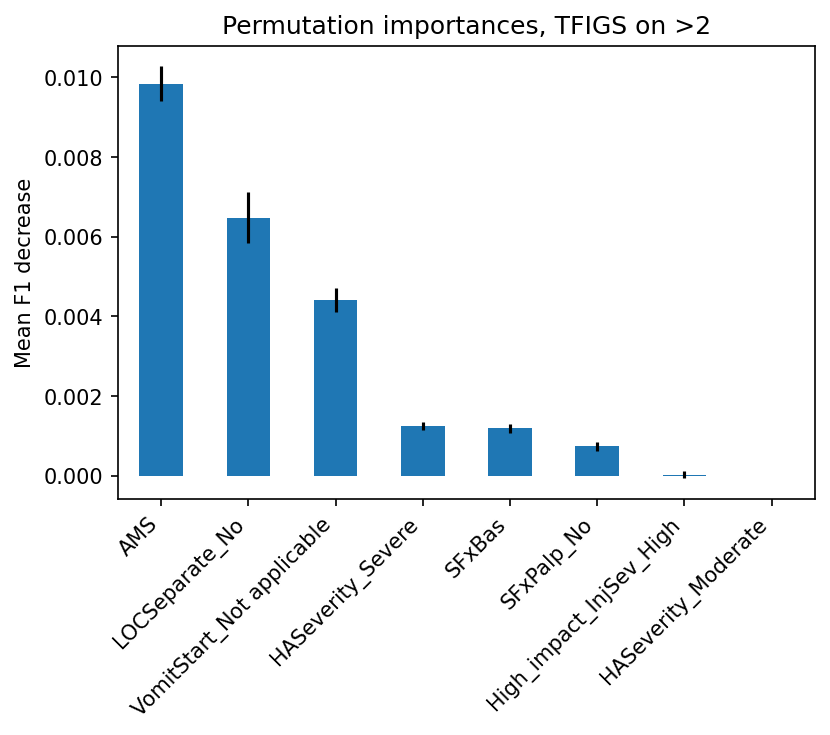

In [71]:
imp_plot('pfigs_old')
plt.title("Permutation importances, TFIGS on >2")